In [2]:
# LOAD LIBRARIES
from scipy import stats
import galpy.potential
from galpy.orbit import Orbit
from astropy import units as u
from galpy.potential import LogarithmicHaloPotential
import numpy as np
from galpy.potential import MWPotential2014,PowerSphericalPotential
#from galpy.potential import FerrersPotential,DehnenBarPotential
import matplotlib.pyplot as plt
#import gala.integrate as gi
#import gala.dynamics as gd
#import gala.potential as gp
#from gala.units import galactic
import astropy.units as u
from orbit_functions import *
import pickle
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from scipy.ndimage import gaussian_filter
from galpy.potential import plotRotcurve
from functools import partial
from scipy.fft import *
from scipy import interpolate, optimize
from astropy.io import fits
from astropy.table import Table, join
import agama

plt.rcParams['font.size'] = 12

# DATA LOADER
class Loader():
    o_cache = None
    o_cache_name = None
    oo = None
    oo_age = None
    oo_orbit = None
    oo_actions = None
    new = False

    def load_model(self, model, time, xmin=1000, xmax=3000, phi_range=0.2, maxvr=20):
        
        if model == 'MW_Sgr':
            Rmax=16.
            snap=str(int(np.round(time*100))) if time>=1 else '0'+str(int(time*100))
            df = Table.read('MW_Sgr/disk'+snap+'.fits', format='fits').to_pandas()
            df['X'],df['Y'],df['Z'],df['VX'],df['VY'],df['VZ']=cyl2cart(df['R'],df['phi'],df['Z'],df['VR'],df['Vphi'],df['VZ'])
            ind=df['R']<Rmax
            df=df[ind]    
            x,y,z,VR,Vphi,VZ,R,phi=df['X'],df['Y'],df['Z'],df['VR'],df['Vphi'],df['VZ'],df['R'],df['phi']
            Vphi=Vphi*-1.
            Lz=R*Vphi
        else:
            if self.o_cache_name == model:
                o = self.o_cache
            else:
                file='o_galpy/o_'+model+'.pkl'
                with open(file, 'rb') as f:#for orbits after perturbation
                    o = pickle.load(f)
                self.o_cache = o
                self.o_cache_name = model

            t=time*u.Gyr
            x=o.x(t)
            y=-o.y(t)#in galpy, orbits turn counterclockwise. changing sign of y we turn it into clockwise
            VR=o.vr(t)
            Vphi=o.vphi(t)*o.r(t)
            R=o.r(t)
            Lz=R*Vphi
            phi=o.phi(t)
            z=None
            VZ=None

        indphi=(np.abs(phi)>np.pi-phi_range)&(np.abs(phi)<np.pi+phi_range)
        indphi&=(np.abs(VR)<maxvr)&(Lz>xmin)&(Lz<xmax)
        x,y,z,VR,Vphi,VZ,R,Lz,phi=x[indphi],y[indphi],z[indphi],VR[indphi],Vphi[indphi],VZ[indphi],R[indphi],Lz[indphi],phi[indphi]
        DATA = False
        
        return x,y,z,VR,Vphi,VZ,R,Lz,phi

    def load_data(self, xmin=1500, xmax=3500, phi_range=0.4, new=True, source_id=False):
        if self.oo == None or self.new != new:
            path = 'o_galpy/SoS_SH_Gaia_test_GAL6D.fits'
            if new:
                path = 'o_galpy/DR3_SH_ruwe14_fidelity05_pioe5_GAL6D.fits'
            self.oo = Table.read(path, format='fits')
        oo = self.oo
        print(oo.keys())
        
        VR,Vphi,VZ,x,y,z,R,phi=np.array((oo['VR'],oo['Vphi'],oo['VZ'],oo['X'],oo['Y'],oo['Z'],oo['R'],oo['phi']))
        sid = np.array(oo['source_id'], dtype=np.int64)
        Lz=-oo['Vphi']*oo['R']
        phi=-np.deg2rad(phi)
        Vphi=-Vphi
        
        indphi = abs(phi) < phi_range
        x,y,z,VR,Vphi,VZ,R,Lz,phi,sid=x[indphi],y[indphi],z[indphi],VR[indphi],Vphi[indphi],VZ[indphi],R[indphi],Lz[indphi],phi[indphi],sid[indphi]
        indphi=(Lz>xmin)&(Lz<xmax)
        x,y,z,VR,Vphi,VZ,R,Lz,phi,sid=x[indphi],y[indphi],z[indphi],VR[indphi],Vphi[indphi],VZ[indphi],R[indphi],Lz[indphi],phi[indphi],sid[indphi]
        
        DATA = True
        if source_id:
            return x,y,z,VR,Vphi,VZ,R,Lz,phi,sid
        return x,y,z,VR,Vphi,VZ,R,Lz,phi
    
    def load_data_ages(self, xmin=1500, xmax=3500, phi_range=0.4):
        #path = 'o_galpy/DR3_SH_ruwe14_fidelity05_pioe5_GAL6D.fits'
        #oo = Table.read(path, format='fits')
        #ages = Table.read('o_galpy/agesGDR3RVS_reduced.fits')
        #joined = join(oo,ages,keys='source_id')
        #print(joined.colnames)
        #print(joined)
        #joined.write('o_galpy/agesGDR3RVS_joined.fits', format='fits')
        #return
        #path = 'o_galpy/agesGDR3RVS_joined.fits'
        #oo = Table.read(path, format='fits')
        #indphi = ~np.isnan(np.array(oo['age']))
        #clean = oo[indphi]
        #clean.write('o_galpy/agesGDR3RVS_clean.fits', format='fits')
        #return
        
        if self.oo_age is None:
            path = 'o_galpy/agesGDR3RVS_clean.fits'
            self.oo_age = Table.read(path, format='fits')
        oo = self.oo_age

        VR,Vphi,VZ,x,y,z,R,phi,age,age_error=np.array((oo['VR'],oo['Vphi'],oo['VZ'],oo['X'],oo['Y'],oo['Z'],oo['R'],oo['phi'],oo['age'],oo['age_error']))
        Lz=-oo['Vphi']*oo['R']
        phi=-np.deg2rad(phi)
        Vphi=-Vphi
        
        indphi = abs(phi) < phi_range
        indphi &= (Lz>xmin)&(Lz<xmax)
        x,y,z,VR,Vphi,VZ,R,Lz,phi,age,age_error=x[indphi],y[indphi],z[indphi],VR[indphi],Vphi[indphi],VZ[indphi],R[indphi],Lz[indphi],phi[indphi],age[indphi],age_error[indphi]
        
        DATA = True
        return x,y,z,VR,Vphi,VZ,R,Lz,phi,age,age_error
    
    def load_data_orbits(self, xmin=1500, xmax=3500, phi_range=0.4):
        if self.oo_orbit is None:
            path = 'o_galpy/orbitsGDR3RVS_joined.fits'
            self.oo_orbit = Table.read(path, format='fits')
        oo = self.oo_orbit

        VR,Vphi,VZ,x,y,z,R,phi,Zmax,Jz,Jr=np.array((oo['VR'],oo['Vphi'],oo['VZ'],oo['X'],oo['Y'],oo['Z'],oo['R'],oo['phi'],oo['Zmax_med_dgeo'],oo['Jz_med_dgeo'],oo['Jr_med_dgeo']))
        Lz=-oo['Vphi']*oo['R']
        phi=-np.deg2rad(phi)
        Vphi=-Vphi
        
        indphi = abs(phi) < phi_range
        indphi &= (Lz>xmin)&(Lz<xmax)
        x,y,z,VR,Vphi,VZ,R,Lz,phi,Zmax,Jz,Jr=x[indphi],y[indphi],z[indphi],VR[indphi],Vphi[indphi],VZ[indphi],R[indphi],Lz[indphi],phi[indphi],Zmax[indphi],Jz[indphi],Jr[indphi]
        
        DATA = True
        return x,y,z,VR,Vphi,VZ,R,Lz,phi,Zmax,Jz,Jr
    
    def load_data_actions(self, xmin, xmax, phi_range):
        if self.oo_actions is None:
            self.oo_actions = Table.read('actions_joined.fits', format='fits')
        tj = self.oo_actions
        
        lst = ('source_id','X','Y','Z','VR','Vphi','VZ','R','phi', 'JR', 'JZ', 'JPhi', 'angleR', 'angleZ', 'anglePhi', 'freqR', 'freqZ', 'freqPhi')
        source_id,x,y,z,VR,Vphi,VZ,R,phi,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi = (tj[i] for i in lst)
        Lz = -R * Vphi
        phi = -phi
        Vphi = -Vphi
        
        indphi = ~np.isnan(Jr)
        indphi &= abs(phi) < phi_range
        indphi &= (Lz>xmin)&(Lz<xmax)
        source_id,x,y,z,VR,Vphi,VZ,R,phi,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi,Lz = (i[indphi] for i in (source_id,x,y,z,VR,Vphi,VZ,R,phi,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi,Lz))
        
        return source_id,x,y,z,VR,Vphi,VZ,R,phi,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi,Lz
    
l = Loader()

# AUXILIARY_FUNCTIONS

def smooth_bins(x, y, xmin, xmax, binsize, calc_error=False,median=False):
    binsLZ=np.arange(xmin,xmax,binsize)
    nx = np.arange(xmin-binsize/2, xmax, binsize)
    xpol = nx + binsize/2
    means = []
    error = []
    for k in nx:
        rel = y[(k<x) & (x<k+binsize)]
        if len(rel) == 0:
            if len(means) == 0:
                means.append(0)
                error.append(0)
            else:
                means.append(means[-1])
                error.append(error[-1])
        else:
            if median:
                if np.isnan(np.ma.median(rel)):
                    print(rel)
                means.append(np.ma.median(rel))
            else:
                means.append(np.mean(rel))
            err = np.std(rel)/np.sqrt(len(rel))
            error.append(err)
    ypol = np.array(means)
    error = np.array(error)
    if calc_error:
        return xpol, ypol, error
    return xpol, ypol


In [3]:
x,y,z,VR,Vphi,VZ,R,Lz,phi,source_id=l.load_data(xmin=float('-inf'), xmax=float('inf'), phi_range=np.pi, source_id=True)
DATA = True
phi = -phi
x2,y2,z2,Vx,Vy,Vz2 = cyl2cart(R,phi,z,VR,Vphi,VZ)

agama.setUnits(length=1, velocity=1, mass=1) 
pos = np.dstack((x,y,z,Vx,Vy,VZ))[0]
mass = np.ones(len(x)) * 12000
pot_nbody = agama.Potential(file="McMillan17_sym.ini", scale=[(240/233.09)**2,1])



af = agama.ActionFinderAxisymFudge(pot_nbody, interp=False)
act, ang, freq = af(pos, angles=True)
print(act)

['VR', 'Vphi', 'VZ', 'X', 'Y', 'Z', 'R', 'phi', 'source_id']


In [9]:
# Compute actions given positions, velocities and a potential curve (McMillan17)

x,y,z,VR,Vphi,VZ,R,Lz,phi,source_id=l.load_data(xmin=float('-inf'), xmax=float('inf'), phi_range=np.pi, source_id=True)
DATA = True

_,_,_,Vx,Vy,_ = cyl2cart(R,phi,z,VR,Vphi,VZ)
Vy = -Vy

agama.setUnits(length=1, velocity=1, mass=1) 
pos = np.dstack((x,y,z,Vx,Vy,VZ))[0]
mass = np.ones(len(x)) * 12000

pot_nbody = agama.Potential(file="McMillan17_sym.ini", scale=[(240/233.09)**2,1])

af = agama.ActionFinder(pot_nbody, interp=False)
act, ang, freq = af(pos, angles=True)
print(act)

t = Table([source_id, act[:,0], act[:,1], act[:,2], ang[:,0], ang[:,1], ang[:,2], freq[:,0], freq[:,1], freq[:,2]],
          names=('source_id', 'JR', 'JZ', 'JPhi', 'angleR', 'angleZ', 'anglePhi', 'freqR', 'freqZ', 'freqPhi'),
          dtype=(['int64']+['float64']*9))
t.write('actions.fits', format='fits', overwrite=True)

['VR', 'Vphi', 'VZ', 'X', 'Y', 'Z', 'R', 'phi', 'source_id']
[[           nan            nan  3264.61534929]
 [           nan            nan -4740.46876928]
 [           nan            nan   262.14935137]
 ...
 [           nan            nan -4610.91615478]
 [           nan            nan -1436.75453993]
 [           nan            nan  -325.65278781]]


In [3]:
# Save table with actions, positions and velocities for later use

t = Table.read('actions.fits', format='fits')
path = 'o_galpy/DR3_SH_ruwe14_fidelity05_pioe5_GAL6D.fits'
d = Table.read(path, format='fits')

joined = join(d, t, keys='source_id')
joined.write('actions_joined.fits', format='fits', overwrite=True)

344 25397569


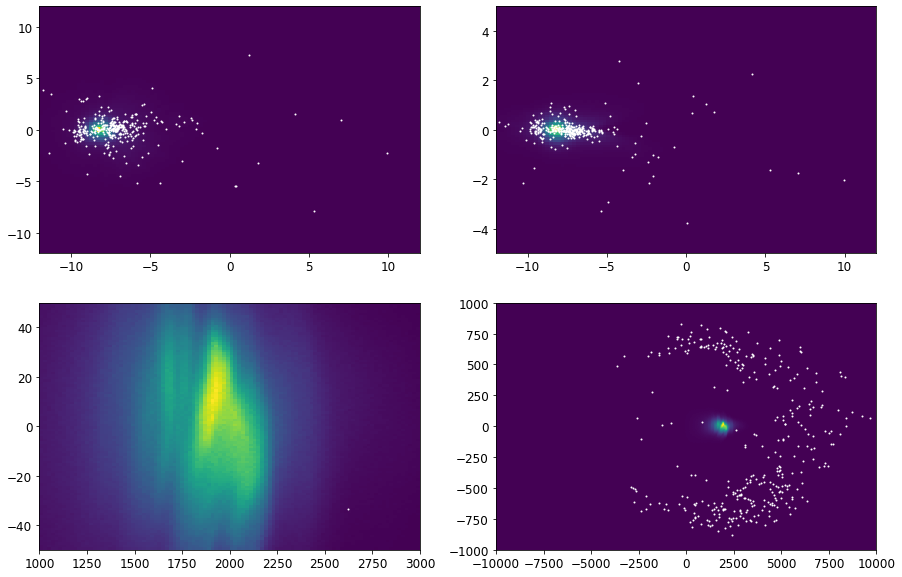

In [10]:
# Plot NaN values from the calculation of actions

t = Table.read('actions.fits', format='fits')
source_id,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi = (t[i] for i in ('source_id', 'JR', 'JZ', 'JPhi', 'angleR', 'angleZ', 'anglePhi', 'freqR', 'freqZ', 'freqPhi'))
isn = np.isnan(Jr)
fig, ax = plt.subplots(2,2,figsize=(15,10))
print(np.count_nonzero(isn),len(isn))
ax[0][0].hist2d(x, y, bins=100, range=[[-12,12],[-12,12]])
ax[0][0].scatter(x[isn], y[isn], s=1, c='w')
ax[0][1].hist2d(x, z, bins=100, range=[[-12,12],[-5,5]])
ax[0][1].scatter(x[isn], z[isn], s=1, c='w')

ax[1][0].hist2d(Lz, VR, bins=100, range=[[1000,3000],[-50,50]])
ax[1][0].scatter(Lz[isn], VR[isn], s=1, c='w')
ax[1][1].hist2d(Lz, VR, bins=500, range=[[-10000,10000],[-1000,1000]])
ax[1][1].scatter(Lz[isn], VR[isn], s=1, c='w')

In [11]:
# Join the computed actions and the actions from another source into a single table
# and show the value of the discrepancy between them

t = Table.read('actions.fits', format='fits')
path = 'o_galpy/orbitsGDR3RVS_joined.fits'
old = Table.read(path, format='fits')
print(old.keys())
old_and_new = join(old, t, keys='source_id')

# Free memory (the files are large)
del old
del t
import gc
gc.collect()

error = 2*np.abs(old_and_new['JR'] - old_and_new['Jr_med_dgeo']) / np.mean(old_and_new['JR'] + old_and_new['Jr_med_dgeo'])
error = error[~np.isnan(error)]
print('Mean relative error (JR):', np.mean(error))
print('Median relative error (JR):', np.median(error))
error = 2*np.abs(old_and_new['JZ'] - old_and_new['Jz_med_dgeo']) / np.mean(old_and_new['JZ'] + old_and_new['Jz_med_dgeo'])
error = error[~np.isnan(error)]
print('Mean relative error (JZ):', np.mean(error))
print('Median relative error (JZ):', np.median(error))

old_and_new.write('actions_both.fits',overwrite=True)

['VR', 'Vphi', 'VZ', 'X', 'Y', 'Z', 'R', 'phi', 'source_id', 'e_med_dgeo', 'Zmax_med_dgeo', 'Jr_med_dgeo', 'Jz_med_dgeo', 'rperi_med_dgeo', 'rapo_med_dgeo']
Mean relative error (JR): 0.14260893469700792
 /home/hpc/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:753: UserWarning:Warning: 'partition' will ignore the 'mask' of the MaskedColumn.

Median relative error (JR): 0.09287783231402742
Mean relative error (JZ): 0.1249125930053163
Median relative error (JZ): 0.009988262319973316


Text(0.5, 1.0, 'JPhi')

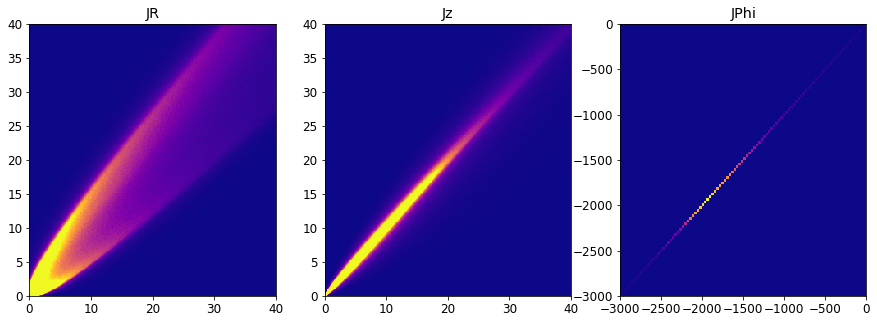

In [12]:
# Density plot computed actions vs the other actions

old_and_new = Table.read('actions_both.fits', format='fits')

fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].hist2d(old_and_new['JR'][~np.isnan(old_and_new['JR'])], old_and_new['Jr_med_dgeo'][~np.isnan(old_and_new['JR'])], bins=300, range=[[0,40],[0,40]], vmax=1500, cmap='plasma');
ax[1].hist2d(old_and_new['JZ'][~np.isnan(old_and_new['JZ'])], old_and_new['Jz_med_dgeo'][~np.isnan(old_and_new['JZ'])], bins=300, range=[[0,40],[0,40]], vmax=1500, cmap='plasma');
ax[2].hist2d(old_and_new['JPhi'][~np.isnan(old_and_new['JPhi'])], (old_and_new['R']*old_and_new['Vphi'])[~np.isnan(old_and_new['JPhi'])], bins=100, range=[[-3000,0],[-3000,0]], cmap='plasma');
#ax[0].plot([0,300],[0,300],c='w',lw=0.5)
#ax[1].plot([0,300],[0,300],c='w',lw=0.5)
#ax[2].plot([0,300],[0,300],c='w',lw=0.5)
ax[0].set_title('JR')
ax[1].set_title('Jz')
ax[2].set_title('JPhi')

(500.0, 3000.0)

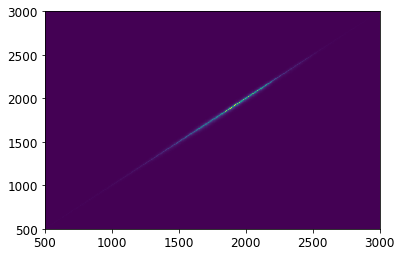

In [10]:
# Lz vs Jphi (they should be identical)

XMIN=0
XMAX=4000
source_id,x,y,z,VR,Vphi,VZ,R,phi,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi,Lz = l.load_data_actions(XMIN, XMAX, np.pi) 
plt.hist2d(Lz, Jphi, bins=1000);
plt.xlim(500,3000)
plt.ylim(500,3000)

In [6]:
# Join the table of actions and a table of estimated ages of stars

path = 'actions_both.fits'
oo = Table.read(path, format='fits')

path = 'o_galpy/agesGDR3RVS_clean.fits'
ot = Table.read(path, format='fits')
joined = join(ot, oo, keys_left=['source_id'], keys_right=['source_id'])

# Liberate memory
del oo
del ot
import gc
gc.collect()

18

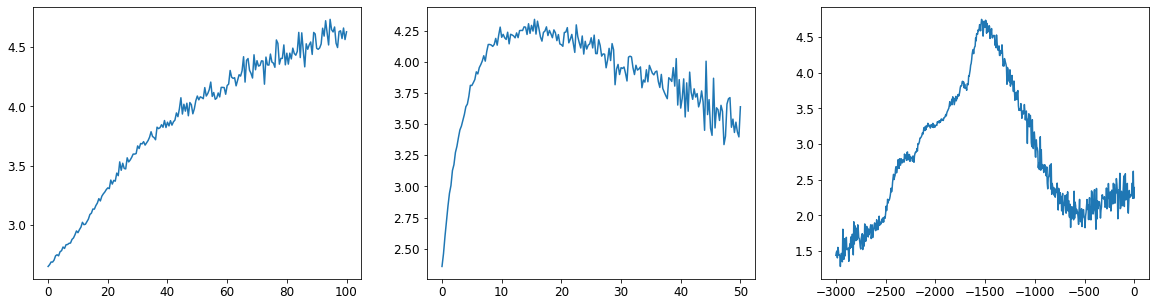

In [15]:
# Plot actions vs ages

fig, ax = plt.subplots(1,3,figsize=(20,5))

nx, ny = smooth_bins(joined['JR'], joined['age'], 0, 100, 0.5, median=True)
ax[0].plot(nx,ny)

nx, ny = smooth_bins(joined['JZ'], joined['age'], 0, 50, 0.25, median=True)
ax[1].plot(nx,ny)

nx, ny = smooth_bins(joined['JPhi'], joined['age'], -3000, 0, 5, median=True)
ax[2].plot(nx,ny)

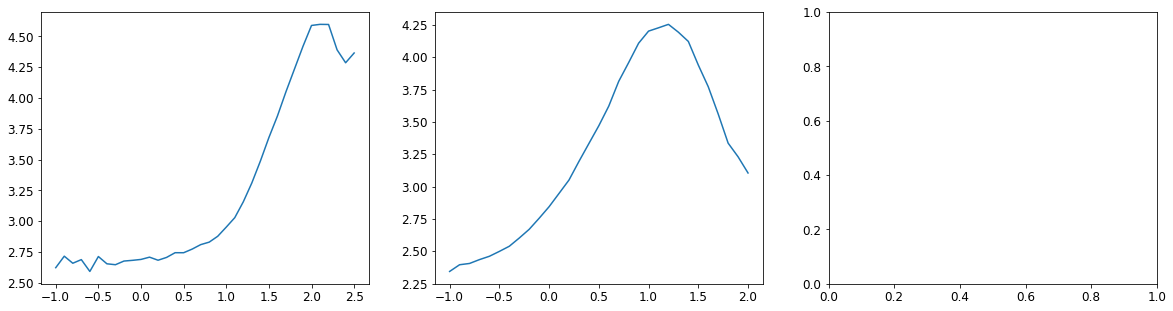

In [14]:
# Plot log10(actions) vs ages

fig, ax = plt.subplots(1,3,figsize=(20,5))

nx, ny = smooth_bins(np.log10(joined['JR']), joined['age'], -1, 2.5, 0.1, median=True)
ax[0].plot(nx,ny)

nx, ny = smooth_bins(np.log10(joined['JZ']), joined['age'], -1, 2, 0.1, median=True)
ax[1].plot(nx,ny)


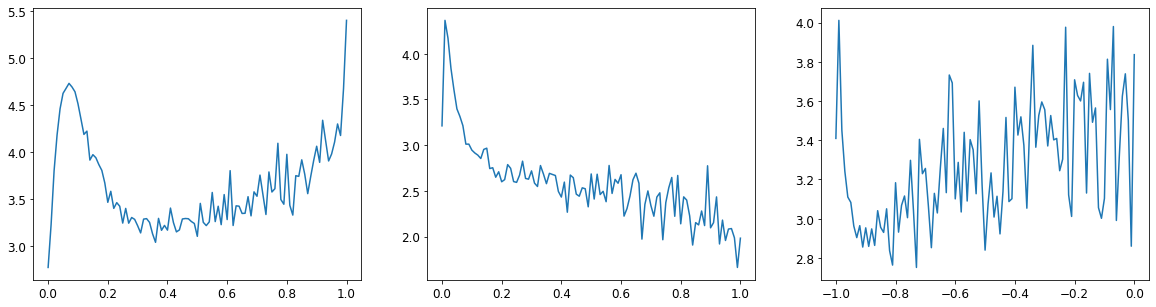

In [10]:
# Plot relative actions vs ages

fig, ax = plt.subplots(1,3,figsize=(20,5))

norm = np.sqrt(joined['JR']**2 + joined['JZ']**2 + joined['JPhi']**2)
nx, ny = smooth_bins(joined['JR']/norm, joined['age'], 0, 1, 0.01, median=True)
ax[0].plot(nx,ny)

nx, ny = smooth_bins(joined['JZ']/norm, joined['age'], 0, 1, 0.01, median=True)
ax[1].plot(nx,ny)

nx, ny = smooth_bins(joined['JPhi']/norm, joined['age'], -1, 0, 0.01, median=True)
ax[2].plot(nx,ny)

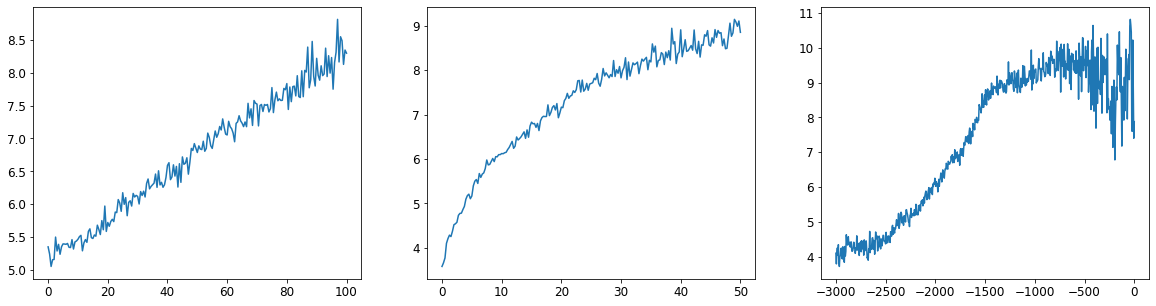

In [5]:
# Same but with another table of ages

oo = Table.read('APOGEE_DR17_MASTER_Dec2022.fits', format='fits')
oo = oo[oo['GaiaEDR3_sourceID'] > 0]

path = 'actions_both.fits'
ot = Table.read(path, format='fits')

joined = join(ot, oo, keys_left=['source_id'], keys_right=['GaiaEDR3_sourceID'])

# Liberate memory
del oo
del ot
import gc
gc.collect()

fig, ax = plt.subplots(1,3,figsize=(20,5))
age_col = 'Chemical_Age_Dec2022'

nx, ny = smooth_bins(joined['JR'], joined[age_col], 0, 100, 0.5, median=False)
ax[0].plot(nx,ny)

nx, ny = smooth_bins(joined['JZ'], joined[age_col], 0, 50, 0.25, median=False)
ax[1].plot(nx,ny)

nx, ny = smooth_bins(joined['JPhi'], joined[age_col], -3000, 0, 5, median=False)
ax[2].plot(nx,ny)

In [ ]:
# Comparison between the two age sources

ages = np.array(joined['Chemical_Age_Dec2022'])
oldages = np.array(joined['age'])
Lz = np.array(-joined['Vphi'] * joined['R'])
VR = np.array(joined['VR'])

nnan = ~(np.isnan(ages))
print(ages[nnan])
print(oldages[nnan])
plt.hist2d(oldages[nnan], ages[nnan], bins=60, range=[[0,6],[0,6]]);
plt.xlabel('Age GDR3RVS')
plt.ylabel('Chemical age')
plt.savefig('ages_comparison.png')